# An Intro to MCMC

Author: Kyle Gersbach

Based on notebooks from [Bence Bécsy](https://github.com/VIPER-Research-Group/gw-school-2022-materials/blob/master/Week_1/Day_5/numerical_bayes_tutorial.ipynb) and [Steve Taylor](https://colab.research.google.com/drive/1ezV5Op2Z5Z2ikM4L_tOTU4fGrc088G1K#scrollTo=z_C4ocbKfWp2&forceEdit=true&sandboxMode=true)


![image](mcmc_meme.png)

Meme from Bence Bécsy

# Notebook plan

The goals of this notebook are to:
 1. Introduce the basic building blocks of datasets
 2. Generate your own dataset
 3. Create a model for your dataset
 3. Create a log likelihood function
 4. Create a prior function
 5. Create a basic MCMC sampler using the Metropolis-Hastings algorithm
 6. Analyze the and understand the outputs
 7. Use a better MCMC sampler (PTMCMC in this case) to re-analyze and compare

And if you get through all that, there are 2 bonus goals:
 8. Learn to destroy signals in a dataset while keeping the statistics the same
 9. Understand how to create the null-distribution for a signal model

 There is a LOT here, so don't worry too much if you don't get through everything. I will include solutions to each task in case you want to skip to a different section.

## Imports are important

PTMCMC will be used later, but first, we will make our own MCMC sampler!

In [2]:
# Magic commands for python notebooks. Not necessary, but nice to have.
%matplotlib inline
%config InlineBackend.figure_format = 'retina' # Increases the default resolution of figures shown

import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm # Used for progress bars

from corner import corner
from PTMCMCSampler.PTMCMCSampler import PTSampler

Optional mpi4py package is not installed.  MPI support is not available.


## Generating your data

For this notebook, you will need to generate your own dataset to analyze. If we recall the best equation where $i$ is the index of our data points:
$$ \rm{Data} = \rm{Signal} + \rm{Noise} \Rightarrow d_i = s_i + n_i ,$$

it becomes clear that we need 2 components for this task:
 1. The signal - What it is you are trying to look for
 2. The noise - The unwanted noise concealing the data

For the first task, we need to create a dataset. For simplicity, we will be using a very simple description for each component. In our signal, lets use a simple sinusoid which we can characterize with 3 parameters: the amplitude (A), the frequency (f, in Hz), and the phase ($\phi$). 
$$s_i = A \, \sin(2\pi f*t_i + \phi)$$

In our noise, we will opt for simple white noise that can be characterized as a 0-mean Gaussian random variable with a standard deviation of 4 (Similar level of variability to the signal). Notice that there is no time dependence in the noise. This will come up later! 
$$n_i = \mathcal{N}(\mu = 0, \sigma)$$


Some helpful functions you may want to use:
- [np.sin()](https://numpy.org/doc/stable/reference/generated/numpy.sin.html) Note that np.sin() can accept an array of values and returns the sine of each element
- [np.random.normal(loc,scale,size)](https://numpy.org/doc/stable/reference/random/generated/numpy.random.normal.html) <- pay close attention to what scale and size represent

In [3]:
time = np.linspace(0,3,500)

# We will reference these values frequently so keep these in mind!

true_amplitude = 2
true_frequency = 1 
true_phase = 3 # Should be between 0 and 2pi

white_noise_std = 3

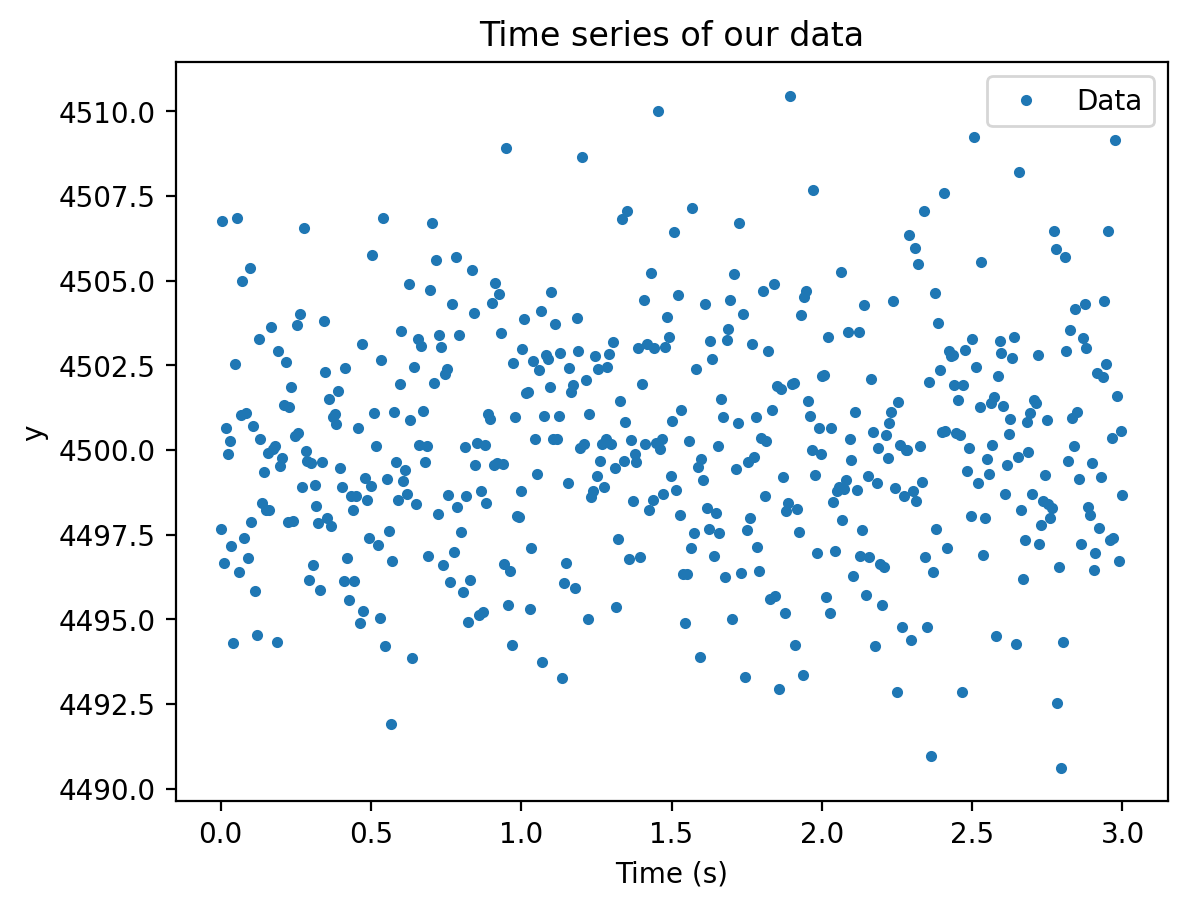

In [4]:
## Task 1: Creating your dataset ##

signal = np.zeros(shape=len(time)) # Replace with your signal
signal = true_amplitude * np.sum(true_phase + true_frequency*time)

noise = np.zeros(shape=len(time)) # Replace with random noise.
noise = np.random.normal(loc=0, scale=white_noise_std, size=len(time))
# Remember, we want a different white noise for every data point, so check your size!

data = signal + noise


# Lets plot it to make sure it works!
plt.plot(time,data,'.',label='Data')
plt.title('Time series of our data')
plt.xlabel('Time (s)')
plt.ylabel('y')
plt.legend()
plt.show()

This cell is just for spacing so you can't see my solution immediately!

<br><br><br><br><br><br><br><br><br><br><br><br><br><br>

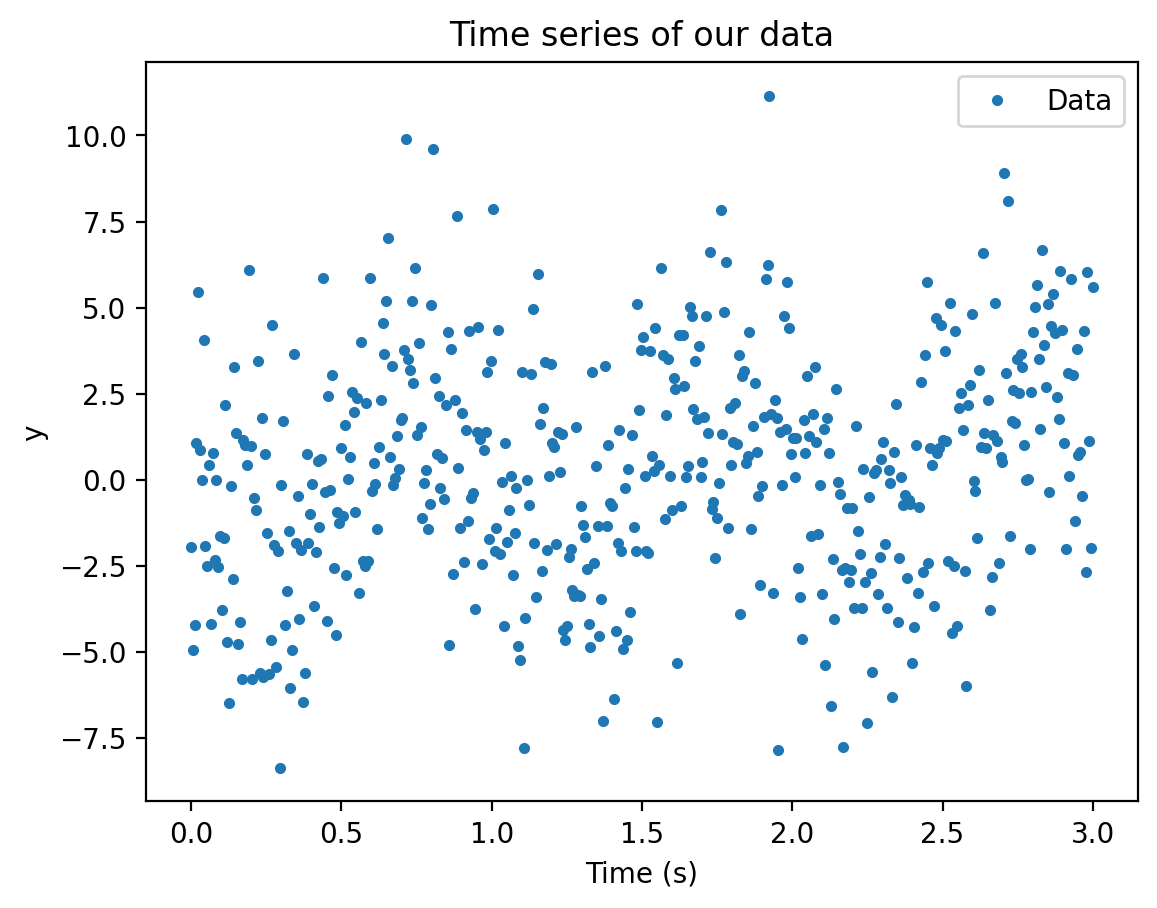

In [7]:
## Task 1: Kyle's solution ##

signal = true_amplitude * np.sin((2*np.pi*true_frequency*time) + true_phase) 
noise = np.random.normal(loc=0, scale=white_noise_std, size=len(time)) 

data = signal + noise


# Lets plot it to make sure it works!
plt.plot(time,data,'.',label='Data')
plt.title('Time series of our data')
plt.xlabel('Time (s)')
plt.ylabel('y')
plt.legend()
plt.show()

## Creating a model

Our next task is to create a model for our signal. Since we know we created a noisy sinusoid, our model will also be a sinusoid. Obviously in real data analysis you don't always know exactly what is in the data, and we will get to that towards the end of the notebook (model selection). 

For this task you need to create a python function which takes in a set of parameters for our model (in this case it would be a list of the [amplitude, frequency, phase]), and returns a signal model corresponding to those parameters. Recall our signal model function:
$$m_i = A \, \sin(2\pi f*t_i + \phi)$$

*Pro tip: You already did this!*

It is important that this function takes in a list (or array, or vector) of all parameter values, as MCMC can work with any number of parameters. This also allows for much easier adaptation later.


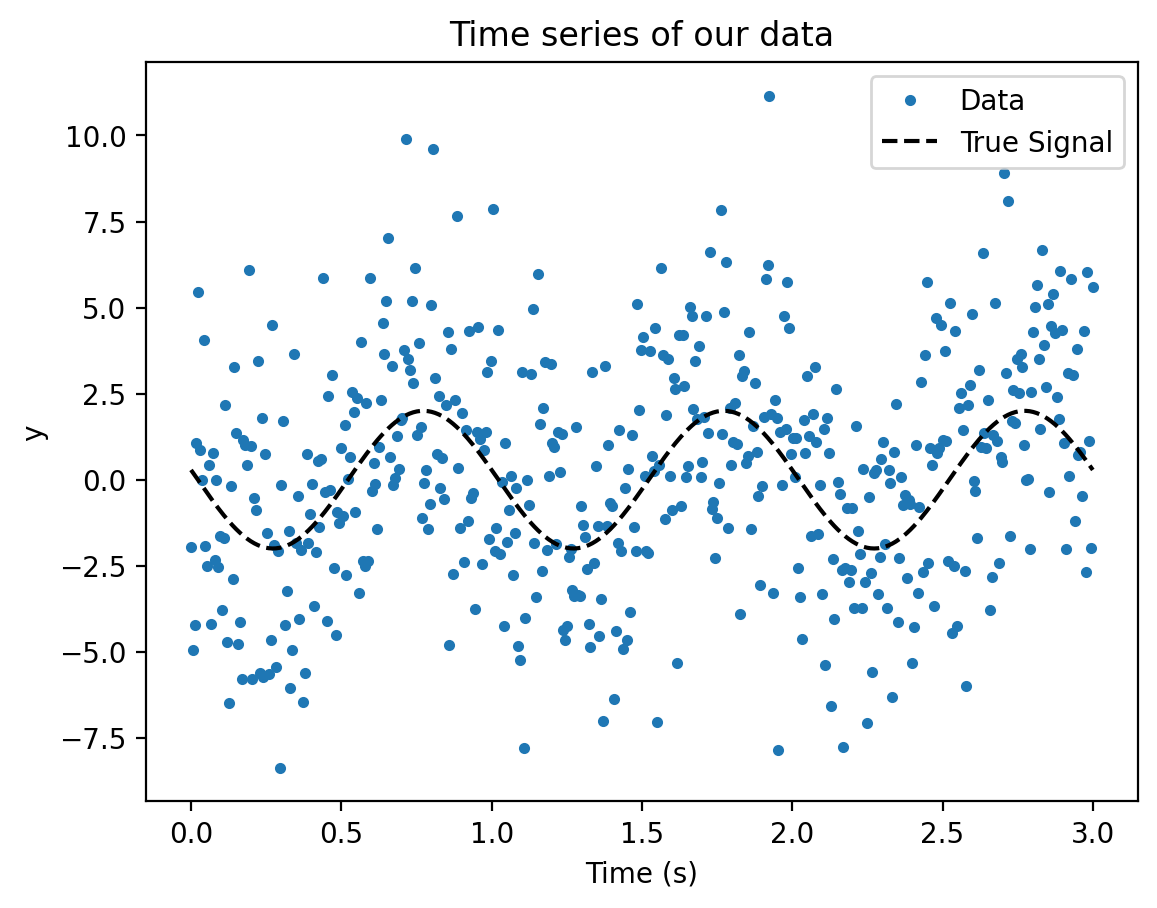

In [8]:
## Task 2: Creating your model ##

def model(params:list):
    A = params[0]
    f = params[1]
    phi = params[2]

    mod = np.zeros(shape=len(time)) # Replace with your signal model here
    mod = A * np.sin(phi + f*time*2*np.pi)
    return mod


# Lets plot it using our real parameters
true_signal = model( [true_amplitude, true_frequency, true_phase] )

plt.plot(time,data,'.',label='Data')
plt.plot(time,true_signal,'--k',label='True Signal')
plt.title('Time series of our data')
plt.xlabel('Time (s)')
plt.ylabel('y')
plt.legend()
plt.show()

Just spacing out the cells so you can't see the answers without scrolling!

<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>

In [ ]:
## Task 2: Kyle's solution ##

def model(params):
    A = params[0]
    f = params[1]
    phi = params[2]

    mod = A * np.sin((2*np.pi*f*time) + phi)

    return mod


# Lets plot it using our real parameters
true_signal = model( [true_amplitude, true_frequency, true_phase] )

plt.plot(time,data,'.',label='Data')
plt.plot(time,true_signal,'--k',label='True Signal')
plt.title('Time series of our data')
plt.xlabel('Time (s)')
plt.ylabel('y')
plt.legend()
plt.show()

## Creating a likelihood function

Let's suppose that you are trying to fit your model to your data and you don't know the true values already. How do you know if your model is a good fit to your data? How do you determine the 'goodness' of a fit?

The first step is to look at our favorite equation again and rearrange things: 
$$d_i = s_i + n_i \Rightarrow d_i - s_i = n_i$$ 

With the right equation, we can see that if we have the exact signal $s_i$, by subtracting our this from our data we should end up with only noise. If we have a model $m_i$ which is close to $s_i$ then $d_i - m_i$ will look like $n_i$! Importantly, $r_i = d_i - m_i$ also has a special name, these are **residuals**. From here on, whenever you see the term residual, think data - model. 

So now we can recast our question not as "how good is our model fit?", but rather, "how much does $d_i - m_i$ look like noise?". Answering this question isn't terribly complicated, and its a fun exercise to see if you can find other forms of likelihood functions, but for this notebook, I'm just going to tell you an answer: the Gaussian likelihood function.

The Gaussian likelihood function is fairly straight forward. It is simply just the product of individual gaussian likelihoods for each residual $r_i = d_i - m_i$. The full equation is: 

$$ p(d|m) = \prod_{i=1}^{N} \frac{1}{\sqrt{2 \pi \sigma_i^2 }} \exp\left(\frac{-(d_i - m_i)^2}{2 \sigma_i^2}\right) .$$

Effectively, the probability that you get data $d$ assuming some model $m$ is the product of of the probability of each residual $r_i$ resulting from only gaussian white noise. 


However, we can see that the product operator is present in this equation. This operator can be dangerous, as in the case with many data points, the resulting likelihood can either be absurdly small (in the case where most $r_i < 1$), or absurdly large (in the case where most $r_i > 1$). This is a problem for computers since we have a limited range of floating point values to use. 

To combat this, it is often much easier to work in log space. We need to rewrite our function for the log space by taking the natural log of the expression. Note that $\ln\left(\prod_i^N a_i\right) = \sum_i^N \ln(a_i) $.


$$ \ln( p(d|m) ) = 
\sum_{i=1}^{N} \left(-\frac{1}{2} \ln(2 \pi \sigma_i^2) - \frac{1}{2}\left(\frac{(d_i - m_i)^2}{ \sigma_i^2}\right) \right) 
= 
- \frac{1}{2} \sum_{i=1}^{N} \ln(2 \pi \sigma_i^2) - \frac{1}{2} \sum_{i=1}^{N} \left(\frac{(d_i - m_i)^2}{ \sigma_i^2}\right) .$$



You might notice a term in this equation we have neglected up to this point: *Uncertianties* $\sigma_i$. While in most cases, this is a hugely important quantity, and we wouldn't want to forget it, however, we can actually make an important simplification due to the way we generated our data. Since we generated each data point's noise exactly the same, each data point has the same uncertainties associated with them. This is called *homoscedastic* data, and it will actually simplifies our equation drastically. 

$$ \ln( p(d|m) ) = 
- \frac{1}{2}N*\ln(2 \pi \sigma^2) - \frac{1}{2\sigma^2} \sum_{i=1}^{N}(d_i - m_i)^2 .
$$

This form is already quite simplified. However, as we will soon see, we actually don't care about the specific value of the likelihood, rather because of the Markov-Chain part of Markov-Chain Monte Carlo (MCMC), we only care about the relative probabilities between different model parameters. This means that constants (as is the case with the first term) and constant factors (as is the case with $\sigma^2$ in the second term) don't actually matter all that much. So we can simplify this AGAIN to write our final log likelihood:

$$ \ln( p(d|m) ) \propto -\sum_{i=1}^{N}(d_i - m_i)^2 .$$
 

Ain't that simple? Do be careful when trying this with your own problems, as heteroscedastic data (different uncertainties) do not simplify the same way. 

Okay, so that was a lot of words, but now we can implement what we've done. 

Your next task will be to implement this log likelihood function. This function needs to take in a list of parameters (exactly the same way as was done with the model) and return the log likelihood value. 

*pro tip: Since your model should take in the exact same parameter list, you do not need to unpack the parameters themselves!*

In [11]:
## Task 3: Creating your log likelihood function ##

def ln_likelihood(params):
    # First calculate your model
    mod = np.zeros(len(time)) # Replace this with an array of your model
    mod = model(params=params)

    # Next, get all of your residuals (hint: r_i = d_i - m_i)
    residuals = np.zeros(len(time)) # Replace this with an array of residuals

    residuals = (data - mod)**2

    # Now calculate the log likelihood! Note that you will need a sum!
    ln_like = 0
    ln_like = -1/2*np.sum(residuals)
    return ln_like
    


Don't mind this! This is just some more spacing!

<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>

In [ ]:
## Task 3: Kyle's solution ##

def ln_likelihood(params):
    # First calculate your model
    mod = model(params)

    # Next, get all of your residuals (hint: r_i = d_i - m_i)
    residuals = data - mod

    # Now calculate the log likelihood! Note that you will need a sum!
    ln_like = -(1/2)*np.sum( residuals**2 )
    return ln_like
    


Now this function has 3 axes, [amplitude, frequency, phase]. If we wanted to represent this, we'd have a hard time doing so considering we only have 3 dimensions and this would be a 4 dimensional plot. Thankfully, we don't need to plot each axis at the same time. We can plot the **conditional probability** of this log likelihood function. This involves fixing two of the three parameters to some specific values, and plotting the log likelihood as a function of the remaining parameter.

Since we know what the injected values are, we can fix each parameter to their injected values before checking each conditional probability

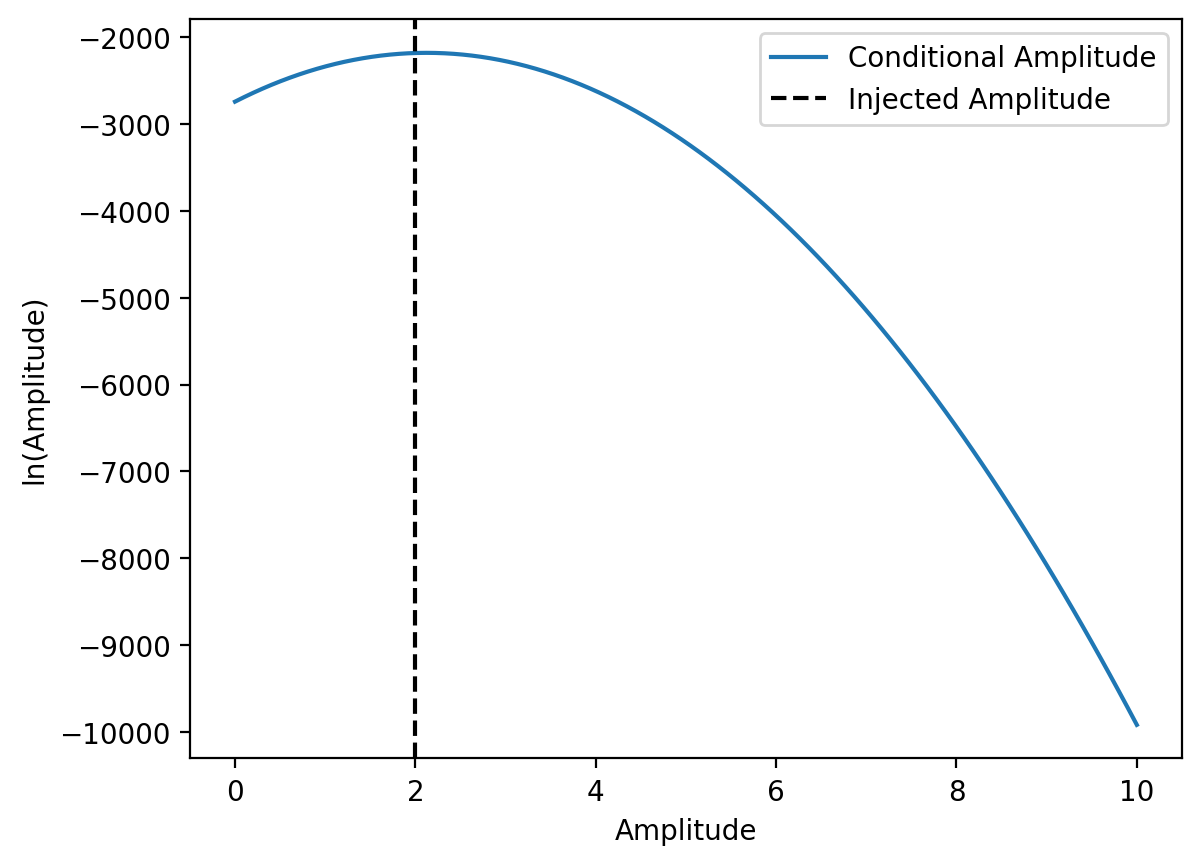

In [13]:
# First lets look at the amplitude
amplitude_range = np.linspace(0,10,100)
amplitude_lnlike = np.zeros_like(amplitude_range)
for i in range(len(amplitude_range)):
    # Remember, ln_likelihood takes in a list/array of parameters in 
    # [amplitude, frequency, phase] order
    amplitude_lnlike[i] = ln_likelihood([amplitude_range[i], true_frequency, true_phase])

plt.plot(amplitude_range,amplitude_lnlike,label='Conditional Amplitude')
plt.axvline(true_amplitude,linestyle='dashed',color='k',label='Injected Amplitude')
plt.xlabel('Amplitude')
plt.ylabel('ln(Amplitude)')
plt.legend()
plt.show()

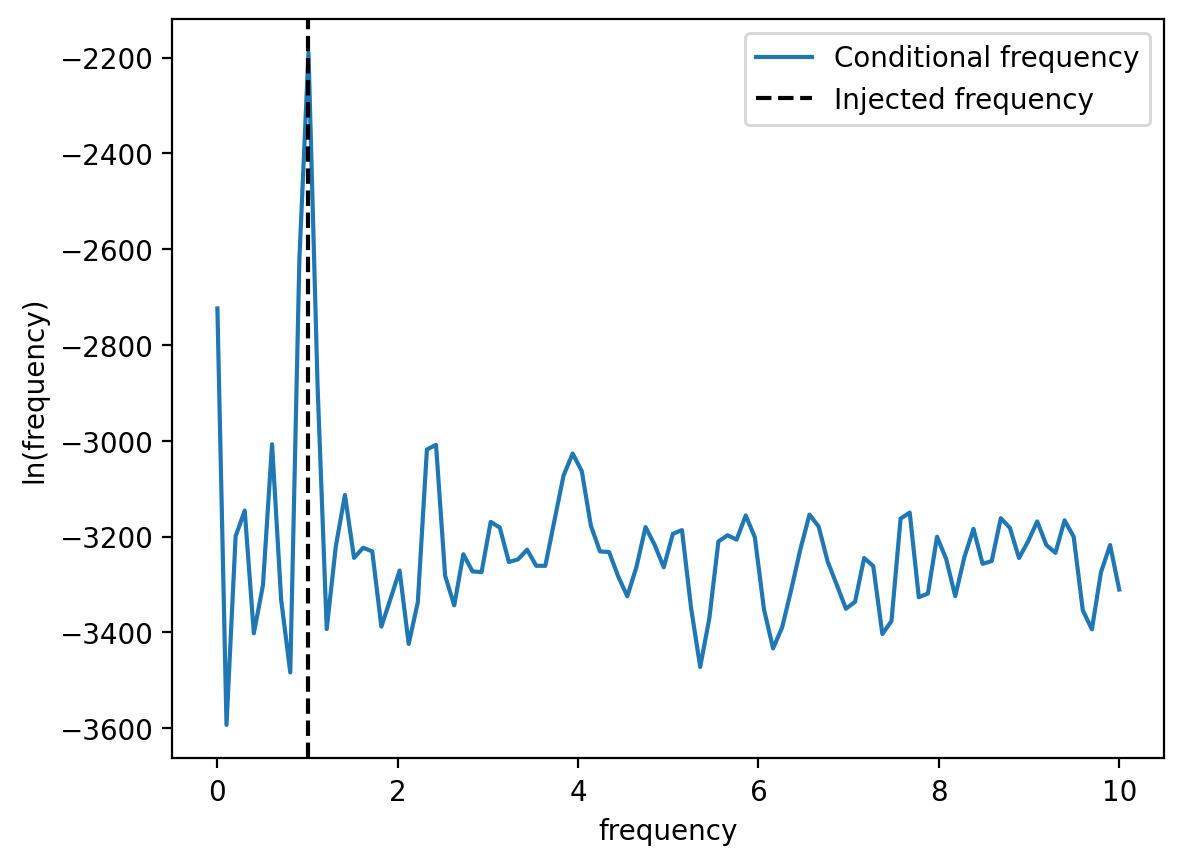

In [14]:
# Next lets look at the frequency
frequency_range = np.linspace(0,10,100)
frequency_lnlike = np.zeros_like(frequency_range)
for i in range(len(frequency_range)):
    # Remember, ln_likelihood takes in a list/array of parameters in 
    # [amplitude, frequency, phase] order
    frequency_lnlike[i] = ln_likelihood([true_amplitude, frequency_range[i], true_phase])

plt.plot(frequency_range,frequency_lnlike,label='Conditional frequency')
plt.axvline(true_frequency,linestyle='dashed',color='k',label='Injected frequency')
plt.xlabel('frequency')
plt.ylabel('ln(frequency)')
plt.legend()
plt.show()

Notice something off about the frequency conditional probability? This jagged behavior in the frequency term is real and not numerical artifacts. This behavior will actually make sampling with our simple sampler pretty hard. But PTMCMC will do it fine!

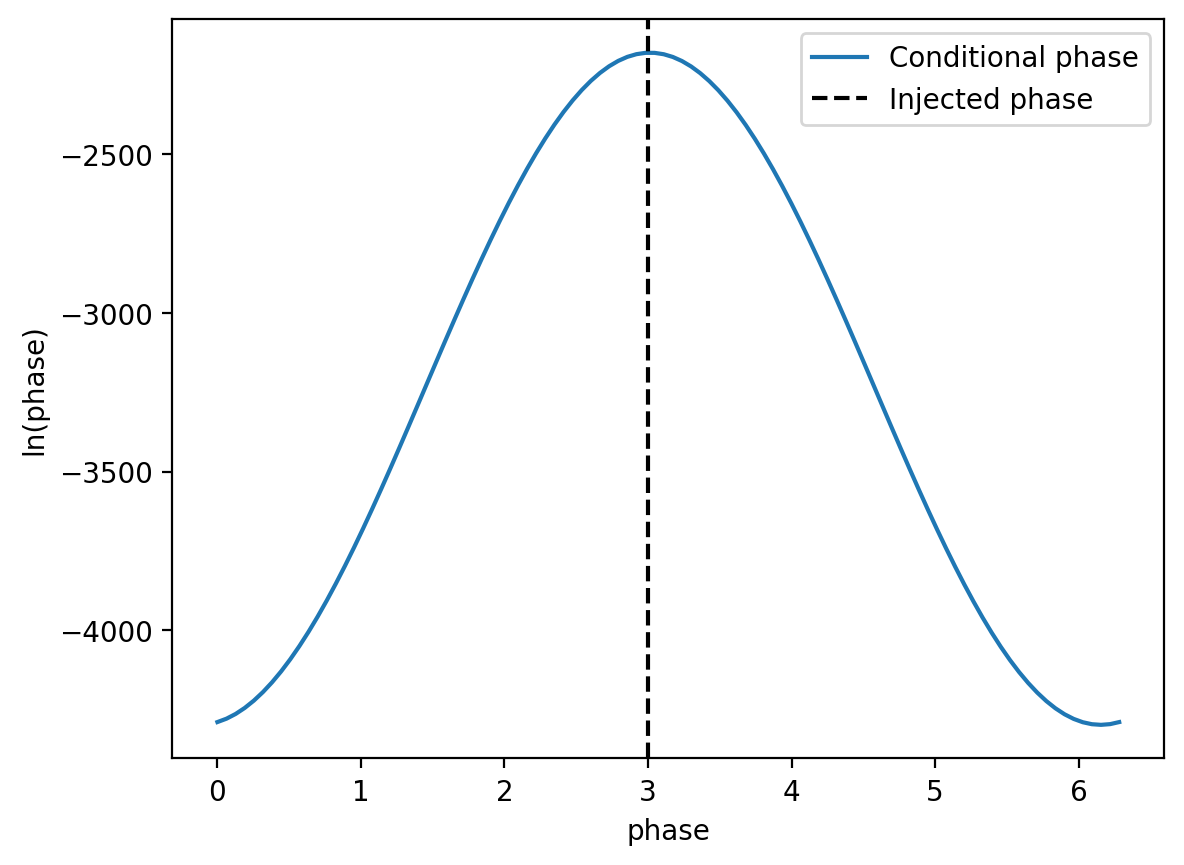

In [15]:
# Next lets look at the frequency
phase_range = np.linspace(0,2*np.pi,100)
phase_lnlike = np.zeros_like(phase_range)
for i in range(len(phase_range)):
    # Remember, ln_likelihood takes in a list/array of parameters in 
    # [amplitude, frequency, phase] order
    phase_lnlike[i] = ln_likelihood([true_amplitude, true_frequency, phase_range[i]])

plt.plot(phase_range,phase_lnlike,label='Conditional phase')
plt.axvline(true_phase,linestyle='dashed',color='k',label='Injected phase')
plt.xlabel('phase')
plt.ylabel('ln(phase)')
plt.legend()
plt.show()

## Creating a prior function

As MCMC is a Bayesian analysis method, we also need to incorporate priors on our parameters. If we pretend that we don't know what signal we injected, it may be best to not assume ANYTHING about the signal that we search for. These are called "uninformed priors". Effectively we want the priors to be as minimally informative as possible to ensure that the recovery is strictly due to the data.

For our case we want to ensure that our prior is uniform across all parameter space. Priors are also where we can set boundaries to our search space. For instance, we want to make sure that we search for a positive amplitude, as negative amplitudes will result in degenerate solutions (multiple parameter sets which produce identical models) which complicate the MCMC search.

When creating a uniform prior we will be effectively creating a piecewise functional form. For ease of search, lets limit our prior range to:
 - $ 0 < \rm{Amplitude} < 10 $
 - $ 0 < \rm{Frequency} < 10 $
 - $ 0 < \rm{Phase} < 2\pi $

If ALL of our parameters meet our criteria then our prior should be a positive number, otherwise it should be 0. The value of that positive number should be based on the volume of the parameter space in question:
$(\Delta A * \Delta f * \Delta \Phi)^{-1} = ((10-0) * (10-0) * (2\pi - 0) )^{-1} = \frac{1}{200\pi}$


Now as with the likelihood function, its often easiest to work in log space, so instead of making a prior function, you should make a log prior function. 

This means that when the parameters are within range, we return 
$\ln \left( \frac{1}{200\pi} \right) = -\ln \left( 200\pi \right)$ 

and when not in range, we return 
$\ln \left(0 \right)$ which asymptotes to $-\infty$. Meaning we should return -np.inf


In [16]:
## Task 4: Creating your log prior function ##

def ln_prior(params):
    """Params are in [amplitude, frequency, phase] order!"""
    amplitude = params[0]
    frequency = params[1]
    phase = params[2]

    # We need to check if our parameters are in range or not!
    # Check amplitude
    if not (0 < amplitude and amplitude < 10):
        amplitude = -np.inf
    # Check frequency
    if not (0 < frequency and frequency <  10):
        frequency = -np.inf

    # Check phase
    if not(0 < phase and phase < 2*np.pi):
        phase = -np.inf
    
    # If we get here, passed all checks!
    return -np.log(200)# Replace with the proper log prior!

Nothing to see here! Just spacing again!

<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>

In [27]:
## Task 4: Kyle's solution ##

def ln_prior(params):
    """Params are in [amplitude, frequency, phase] order!"""
    amplitude = params[0]
    frequency = params[1]
    phase = params[2]

    # We need to check if our parameters are in range or not!
    # Check amplitude
    if amplitude<0 or amplitude>10:
        return -np.inf

    # Check frequency
    if frequency<0 or frequency>10:
        return -np.inf

    # Check phase
    if phase<0 or phase>2*np.pi:
        return -np.inf
    
    # If we get here, passed all checks!
    return -np.log(200*np.pi)# Replace with the proper log prior!

## Creating the MCMC

Now to the whole reason for this notebook, the Markov-Chain Monte Carlo (MCMC). While it may seem intimidating to make your own MCMC, I can assure you its easy to make your first one! We will be implementing the [Metropolis-Hastings algorithm](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm) for MCMC.

The idea behind MCMC is to numerically map out the posterior of each parameter. The way this is done is by exploring the parameter space for likely areas of the posterior space. An MCMC will chose some point, then "jump" to a new point at random. If the point is more likely, then the jump is accepted and the current position is updated. If the point is less likely we now have a probability of jumping to the new point based on the ratio of the posteriors (the Hastings ratio). In this way, we are more likely to map our regions of high probability, but we are also capable of going 'downhill' in the posterior, and the chance of that happening is directly related to how 'steep' the drop off is in posterior. The downhill portion is tremendously important as otherwise the sampler may get stuck in false peaks and would never map out anything but the highest point it finds.

That's a lot of words that may or may not make sense, and that's okay if it doesn't. MCMC is kinda goofy but it is an extraordinarily powerful tool. I like to think of MCMC as a posterior hill climbing algorithm that occasionally likes to walk back down, just in case it finds another, higher peak. 

Here is what an MCMC looks like in action:
![mcmc_gif](https://miro.medium.com/v2/resize:fit:1280/format:webp/0*9oIgSPSeOHx92Ov8.gif)

[Source](https://medium.com/@yoshiyoshiyoshi/probability-theory-in-a-nutshell-crash-course-9d62aa896806)

In this animation, the "fuzzy catepilar" shape on the right is called the traceplot for that parameter and it represents the parameter's value at a particular iteration in the MCMC. The plot on the left-hand side is the probability density function, or PDF of that parameter. Notice how as the sampler acrues more samples, the histogram stabilizes (i.e. the PDF is stationary with many samples). The behavior shown here is exactly the behavior you want to see in an MCMC. 

With that sort-of explained, lets now talk about implementing the MCMC. The centerpiece of Metropolis-Hastings MCMC is the Hastings ratio. This is computed where $m_{new}$ is the proposed parameter array, and $m_{current}$ is the current parameter array:

$$H = \frac{p(d|m_{new})p(m_{new})}{p(d|m_{current})p(m_{current})} $$

Since we are working mostly in log space, we should compute $\ln(H)$

$$\ln(H) = \ln\left(p(d|m_{new})\right) + \ln\left(p(m_{new})\right) - \ln\left(p(d|m_{current})\right) - \ln\left(p(m_{current})\right) $$

 The pseudo code for a Metropolis-Hastings MCMC is as follows:


In [28]:
"""
x0 # Some initial parameter vector guess
chain = np.zeros((N_sampled,N_params)) # Create the chain to store the parameters

current_params = x0 # Set the current parameter vector to the initial guess
chain[0] = current_params # Always "Accept" the first guess

for i in range(N_samples):
    new_params = params + proposal() # Create a new point starting from the old point

    hastings = compute_hastings(new_params, current_params) # Evaluate the Hastings ratio
    
    if hastings > U[0,1]:
        # Accept the proposal
        # Update the current location to the new one
        # Add the new location to the chain
    else:
        # Reject the proposal
        # Keep the current location the same
        # Add a new copy of the current location to the chain

"""

'\nx0 # Some initial parameter vector guess\nchain = np.zeros((N_sampled,N_params)) # Create the chain to store the parameters\n\ncurrent_params = x0 # Set the current parameter vector to the initial guess\nchain[0] = current_params # Always "Accept" the first guess\n\nfor i in range(N_samples):\n    new_params = params + proposal() # Create a new point starting from the old point\n\n    hastings = compute_hastings(new_params, current_params) # Evaluate the Hastings ratio\n    \n    if hastings > U[0,1]:\n        # Accept the proposal\n        # Update the current location to the new one\n        # Add the new location to the chain\n    else:\n        # Reject the proposal\n        # Keep the current location the same\n        # Add a new copy of the current location to the chain\n\n'

Yes, that's actually it. There are much fancier proposal distributions, compared to our random draw, but everything else is exactly the same (At least for Metropolis-Hastings samplers). With this, lets implement all of this!

To not take an huge amount of time, the main body of the MCMC is written for you, you simply have to fill in the Hastings ratio calculation

In [31]:
## Task 5: Compute the hastings ratio ##

def ln_Hastings(proposed_params, current_params):
    # Recall that the log likelihood and log prior functions are:
    # ln_likelihood(params) and ln_prior(params)
    ln_H = ln_likelihood(proposed_params) + ln_prior(proposed_params) - ln_likelihood(current_params) - ln_prior(current_params) 
    
    return ln_H

Nothing to see here! Unless you are stuck, then definitely look ahead at my answer!

<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>

In [32]:
## Task 5: Compute the hastings ratio ##

def ln_Hastings(proposed_params, current_params):
    # Recall that the log likelihood and log prior functions are:
    # ln_likelihood(params) and ln_prior(params)
    ln_H = ln_likelihood(proposed_params) + ln_prior(proposed_params) \
          -ln_likelihood(current_params) - ln_prior(current_params)
    return ln_H

Now lets put that into an MCMC

In [33]:
def MH_MCMC(x0, N, jump_cov):
    """A simple Metropolis-Hastings MCMC

    Args:
        x0 (list): A list of initial guesses to the parameters
        N (int): The number of MCMC iterations to compute
        jump_cov (np.ndarray): The proposal covariance matrix

    Returns:
        np.ndarray: The chain of parameter vectors
    """
    chain = np.zeros((N+1,len(x0)))
    acceptance = 0

    cur_param = np.array(x0)
    chain[0] = cur_param

    for i in tqdm(range(1,N+1),ncols=80,desc='MCMC iterations'):
        # Add a small random gaussian offset to current position
        new_param = cur_param + np.random.multivariate_normal( np.zeros(len(cur_param)), jump_cov)

        # Use hastings ratio to decide on jumping
        ln_H = ln_Hastings(new_param,cur_param)
        if ln_H > 1 or np.exp(ln_H)>np.random.random():
            acceptance+=1
            chain[i] = new_param
            cur_param = new_param
        else:
            chain[i] = cur_param
    
    print(f'Done. Acceptance rate = {100*(acceptance/N)}%')
    return chain 


Okay, so why do we need these parameter inputs (x0 and jump_cov)

x0: Since the MH algorithm needs some starting point, we need to give it some place to start. Random points are fine as long as they are somewhere within the prior range!

jump_cov: This one is tricky. We need some way to jump to new positions in parameter space. The problem is we don't know how far we should be jumping on average! While many samplers (like PTMCMC which you will use later) have methods to 'adapt' their proposal distributions, this simple sampler does not, and as such, this jump_cov can play a major role in how well you sample

In [34]:
# For now I will give the true frequency to the MCMC, but I will give bad guesses for 
# the other 2 parameters. We will come back to this choice soon
x0 = [2, true_frequency, 2]

# Just choose a diagonal covariance matrix. The values represent how big our steps in each 
# parameter should be

cov = np.diag([0.001, 0.00001, 0.001]) 


chain = MH_MCMC(x0,int(5e4),cov)


MCMC iterations: 100%|██████████████████| 50000/50000 [00:17<00:00, 2890.77it/s]

Done. Acceptance rate = 50.648%


## Analyzing the MCMC

This section we can analyze the MCMC chains. There is a lot in this section so here's a list of things to do:
 1. Plot traceplots (importance of burn-in)
 2. Marginal distributions
 3. Importance of jump-scaling and initial guesses 


 First, lets plot the traceplots (parameter values over iterations)

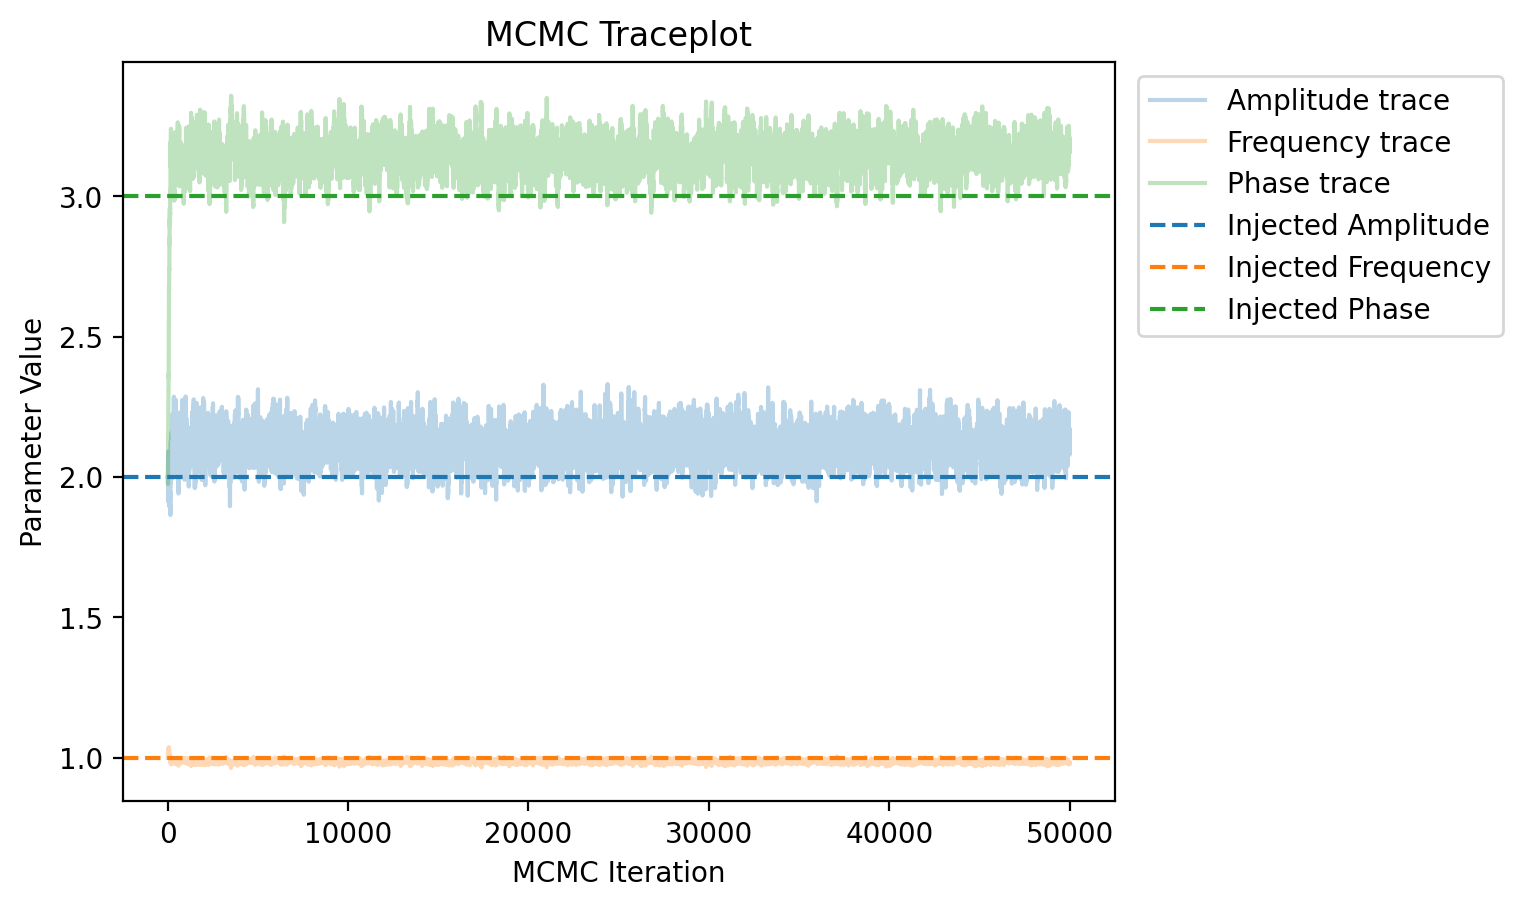

In [35]:
# Plot the trace plots.

plt.plot(chain[:,0],label='Amplitude trace',color='C0',alpha=0.3)
plt.plot(chain[:,1],label='Frequency trace',color='C1',alpha=0.3)
plt.plot(chain[:,2],label='Phase trace',color='C2',alpha=0.3)

plt.axhline(true_amplitude,linestyle='dashed',color='C0',label='Injected Amplitude')
plt.axhline(true_frequency,linestyle='dashed',color='C1',label='Injected Frequency')
plt.axhline(true_phase,linestyle='dashed',color='C2',label='Injected Phase')

plt.title('MCMC Traceplot')
plt.ylabel('Parameter Value')
plt.xlabel('MCMC Iteration')
plt.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left')
plt.show()


These traces should look pretty good. They should all look sorta like "fuzzy catepilars". However, notice at the begining how the amplitude parameter sort of walks its way to higher amplitudes? This phase of an MCMC is called the **burn-in** and is a section of the MCMC in which the parameters are still finding a good peak to climb. These should not be included in the final distributions, so we need to cut them off. 

Its fairly common to cut off burn-in by eye, but you can also just do a much larger cut just to be safe. 

In my traces, burn-in lasts only a few iterations, so I'll be cutting 10%

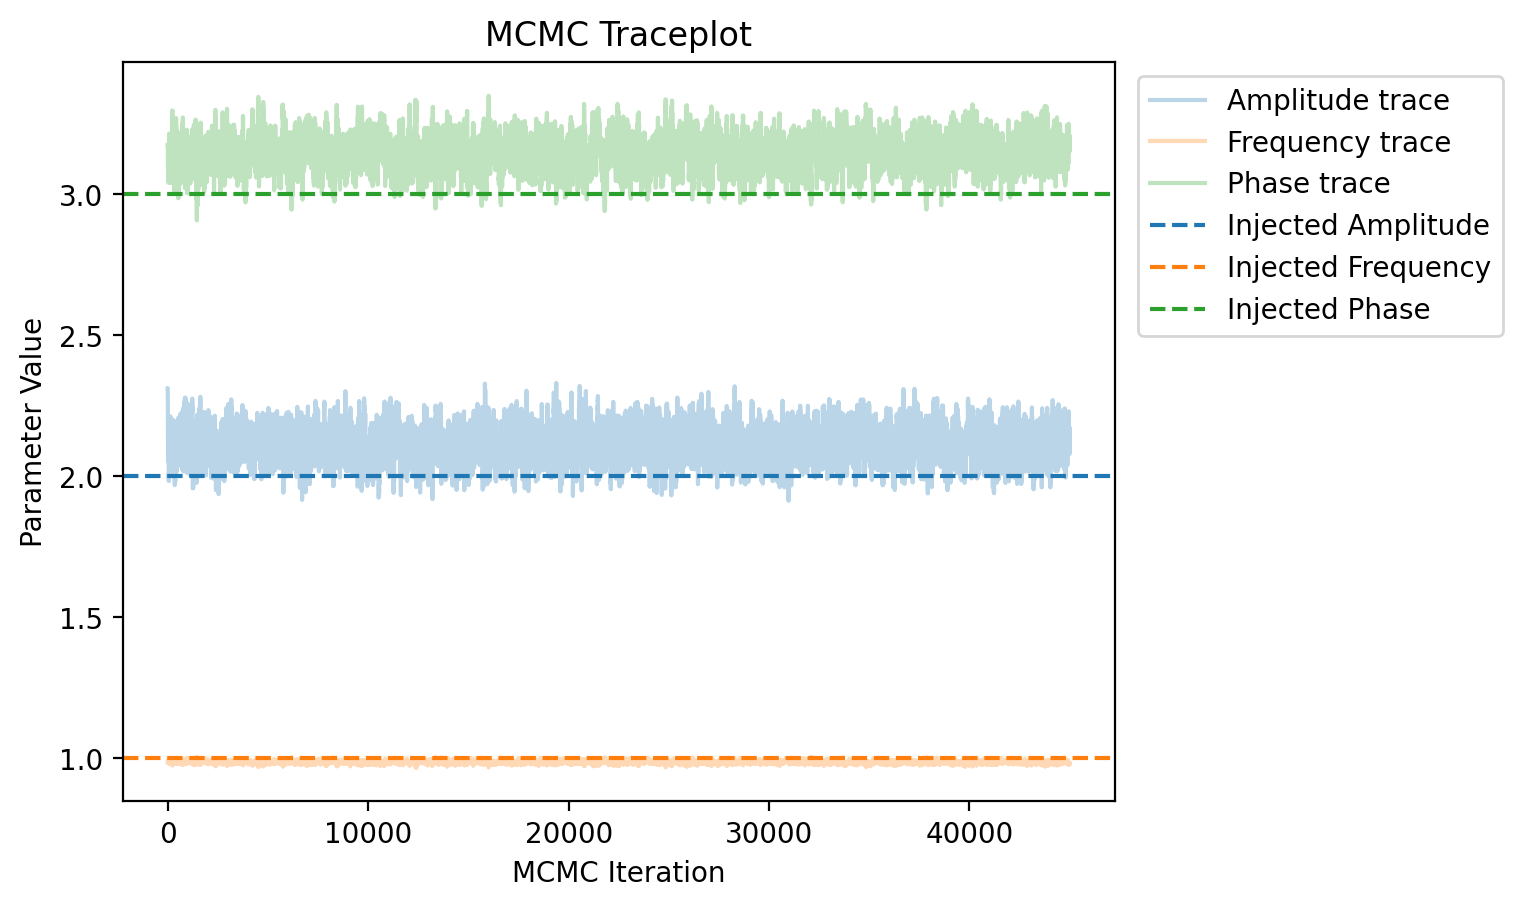

In [36]:
burn = int(len(chain)*0.1)

# Plot the burned-in trace plots.

plt.plot(chain[burn:,0],label='Amplitude trace',color='C0',alpha=0.3)
plt.plot(chain[burn:,1],label='Frequency trace',color='C1',alpha=0.3)
plt.plot(chain[burn:,2],label='Phase trace',color='C2',alpha=0.3)

plt.axhline(true_amplitude,linestyle='dashed',color='C0',label='Injected Amplitude')
plt.axhline(true_frequency,linestyle='dashed',color='C1',label='Injected Frequency')
plt.axhline(true_phase,linestyle='dashed',color='C2',label='Injected Phase')

plt.title('MCMC Traceplot')
plt.ylabel('Parameter Value')
plt.xlabel('MCMC Iteration')
plt.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left')
plt.show()


With this, we can now plot the corner plot. There is a lot in this plot so lets talk. The top diagonal plots are the **marginalized distributions**. These are the distributions on that parameter making no assumptions about the other parameters. These are calculated as:

$$ p(d|\theta_1) = \int p(d|\theta_1,\theta_2,\theta_3) p(\theta_2) p(\theta_3) \, d \theta_2 d \theta_3 $$

Effectively, these are all of the possible $\theta_1$.

In the lower triangle, are 2D marginalized distributions. Effectively they show the same thing as the marginalized distributions, but leaving 2 parameters left. They are especially effective in showing covariances between parameters. Notice how the frequency and phase parameters are highly covariant, but the amplitude isn't covariant with anything else.


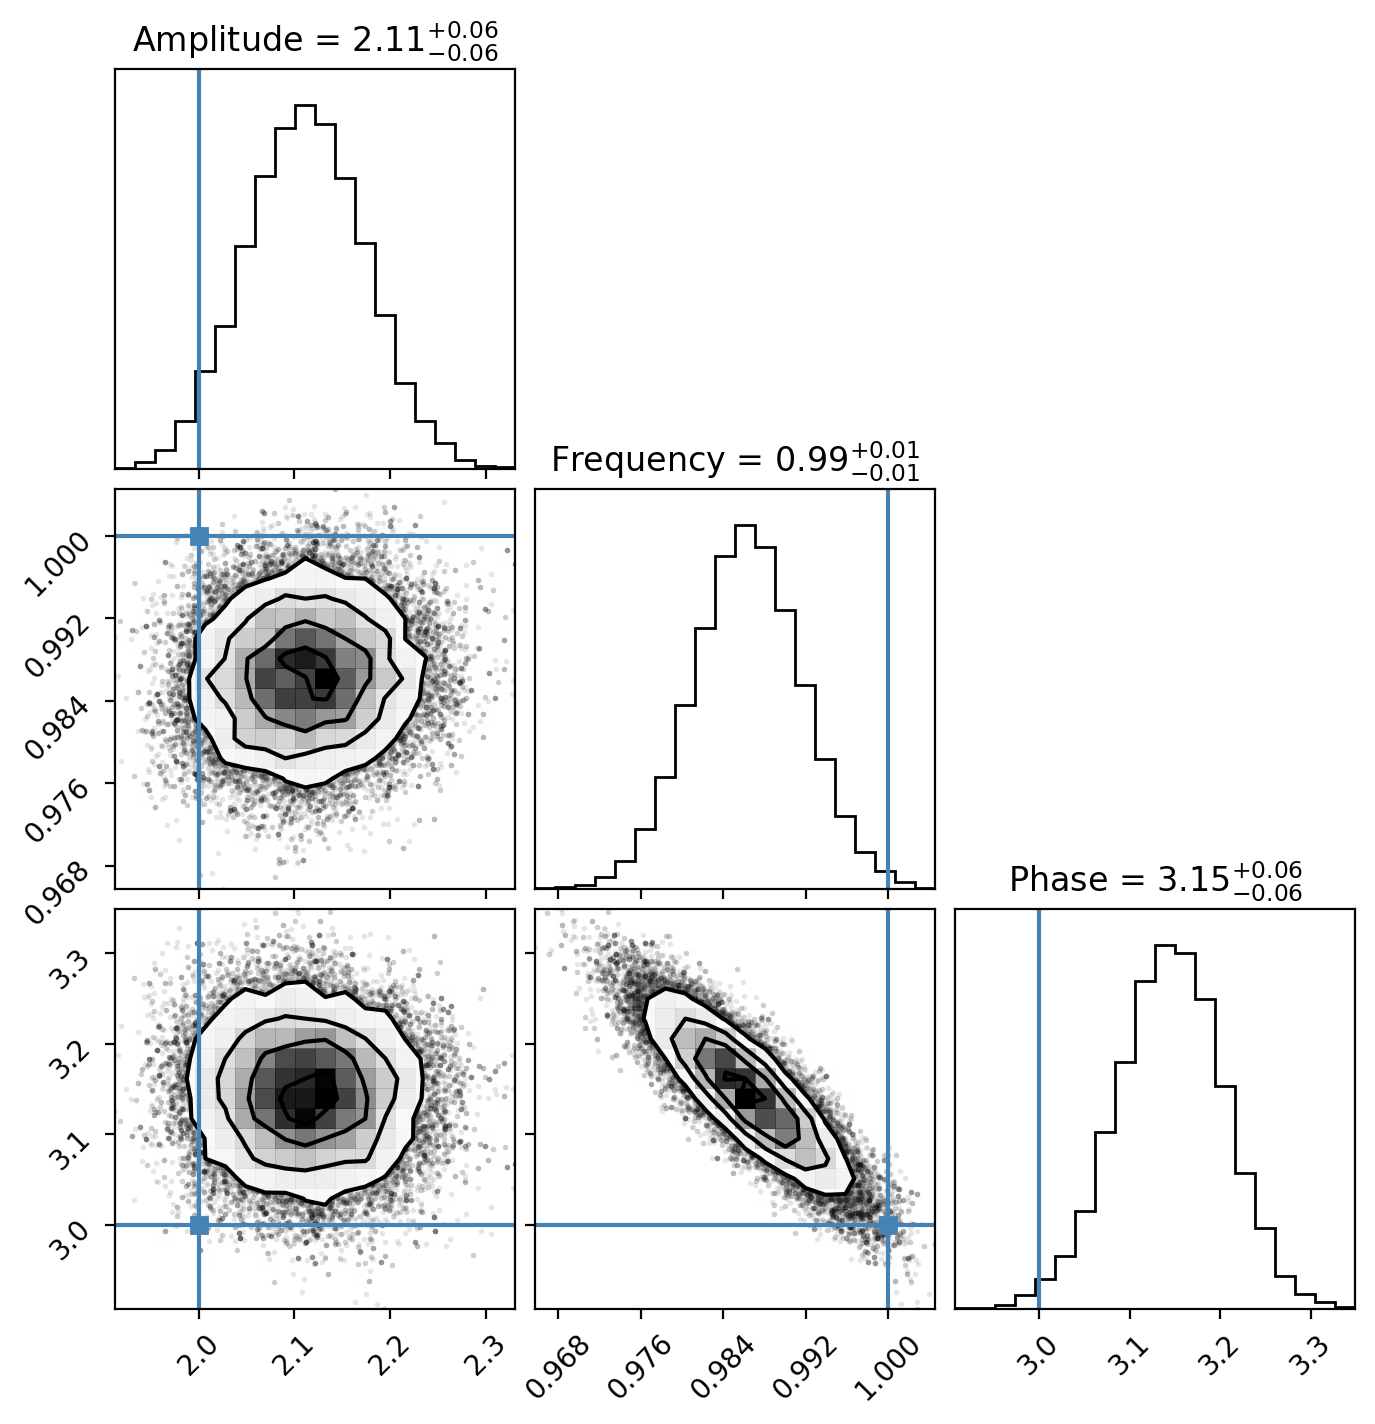

In [37]:
corner(chain[burn:],titles=['Amplitude','Frequency','Phase'],show_titles=True,
       truths=[true_amplitude,true_frequency,true_phase])
plt.show()

You might notice that the injected values aren't always in the distribution. It happens. Especially so with very noisy data like we generated.


**Now lets circle back to the x0 term.**

Lets do an experiment! Lets try setting x0 to [0.01, 0.01, 0.01]. What do you think happens?

MCMC iterations: 100%|██████████████████| 50000/50000 [00:13<00:00, 3593.66it/s]


Done. Acceptance rate = 4.598%


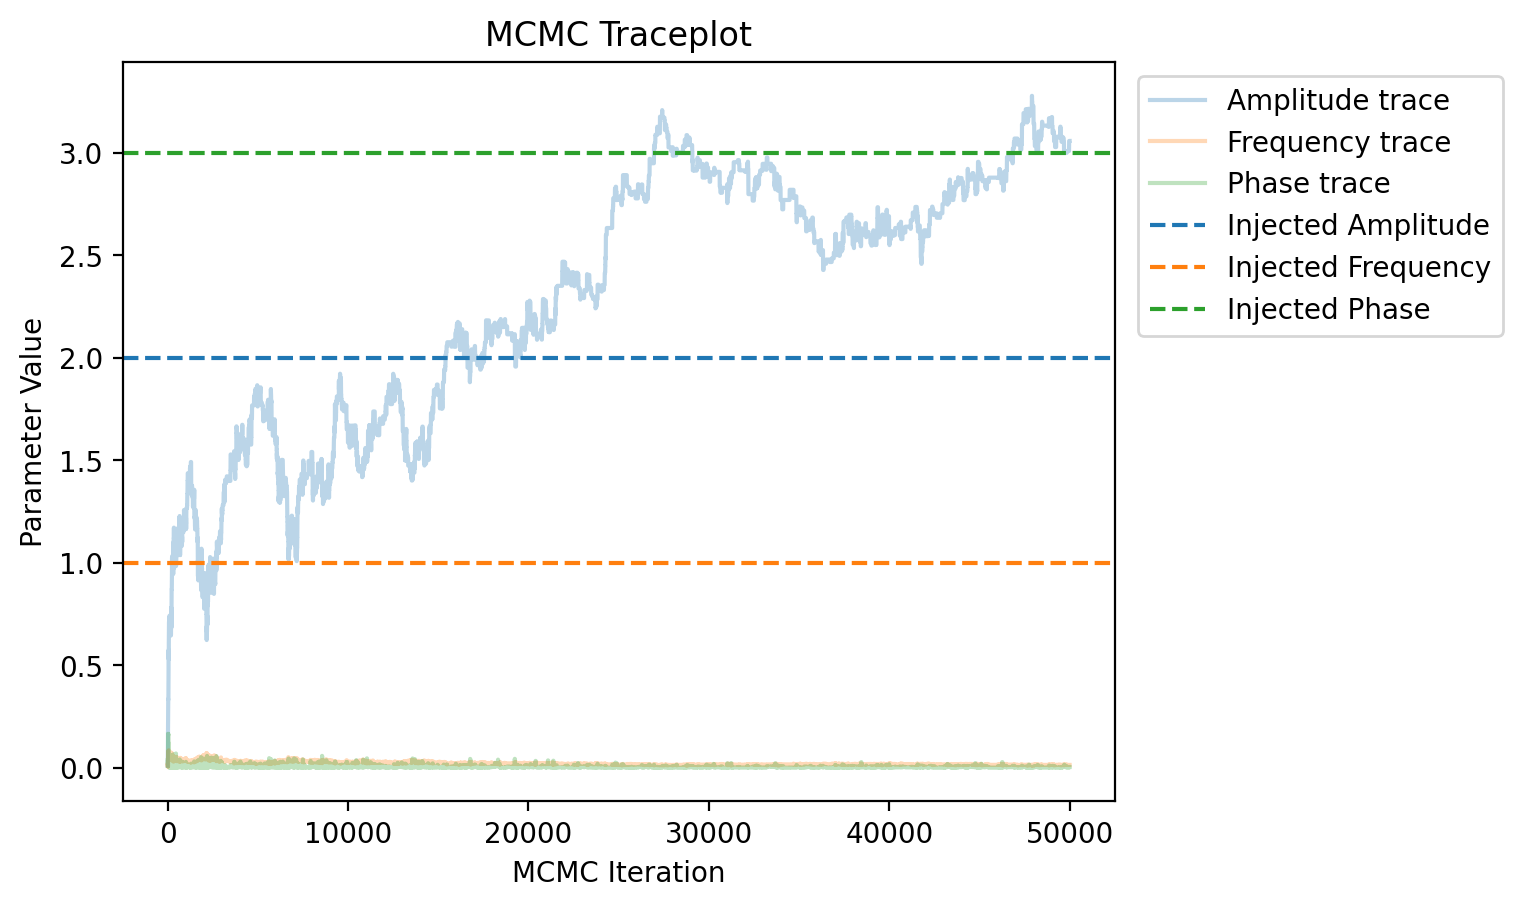

In [45]:
x0 = [0.01, 0.01, 0.01]

cov = np.diag([0.001, 0.0001, 0.001]) 


chain = MH_MCMC(x0,int(5e4),cov)

# Plot the trace plots.

plt.plot(chain[:,0],label='Amplitude trace',color='C0',alpha=0.3)
plt.plot(chain[:,1],label='Frequency trace',color='C1',alpha=0.3)
plt.plot(chain[:,2],label='Phase trace',color='C2',alpha=0.3)

plt.axhline(true_amplitude,linestyle='dashed',color='C0',label='Injected Amplitude')
plt.axhline(true_frequency,linestyle='dashed',color='C1',label='Injected Frequency')
plt.axhline(true_phase,linestyle='dashed',color='C2',label='Injected Phase')

plt.title('MCMC Traceplot')
plt.ylabel('Parameter Value')
plt.xlabel('MCMC Iteration')
plt.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left')
plt.show()


I am willing to bet that it did not pick up on the injected values. (If it didn't, you got lucky!)

But why? Well, the MCMC got stuck. It found a false peak and it the jump scaling wasn't large enough to allow it to jump to a better area. Effectively, the proposed points to jump downhill weren't accepted. This is largely due to the jaggedness of the likelihood surface in the frequency space! (look back at the conditional probabilities!). 

Try experimenting with different choices of starting vector and see what's happening! See if you can find a choice thats far away from the truth while still being able to recover the injection!



*About that jump_cov term*

The jump_cov represents the covariance matrix of random jump from the current parameter vector. In our simple MCMC, this covariance matrix is fixed in place at the time we start searching. This is obviously not optimal, as we want our proposal distribution to look as much like the true distribution as possible, and we don't know what it will look like beforehand! Thats the whole point of searching!

Fortunately there are ways around this. There are many different types of proposal schemes, not just random Gaussian jumps, and even in these random Gaussian jumps there are ways to modify the covariance matrix as the sampler runs (called Adaptive Metropolis-Hastings)


## Using PTMCMC instead!

While we don't have time to go deep into it, we can use a more generalized MCMC sampler:
PTMCMC (Parallel Tempered MCMC). 

And, because of the way I had you build your functions, its now just a plug and play solution!


In [39]:
# Define some location to save the MCMC output
loc = 'SineMCMC/'

# Give it a starting guess
x0 = np.array([1., 1., 1.])

# Give it a starting jump covariance matrix. Don't worry, its adaptive!
cov = np.diag([0.01, 0.01, 0.01]) 

# Construct our sampler using the functions we already made!
sampler = PTSampler(ndim=3, logl=ln_likelihood, logp=ln_prior, cov=cov , outDir=loc)

# Now sample!
sampler.sample(x0, Niter=int(3e5))

Finished 3.33 percent in 1.735233 s Acceptance rate = 0.283556Adding DE jump with weight 20
Finished 100.00 percent in 42.555343 s Acceptance rate = 0.468627
Run Complete


Now lets plot the results!

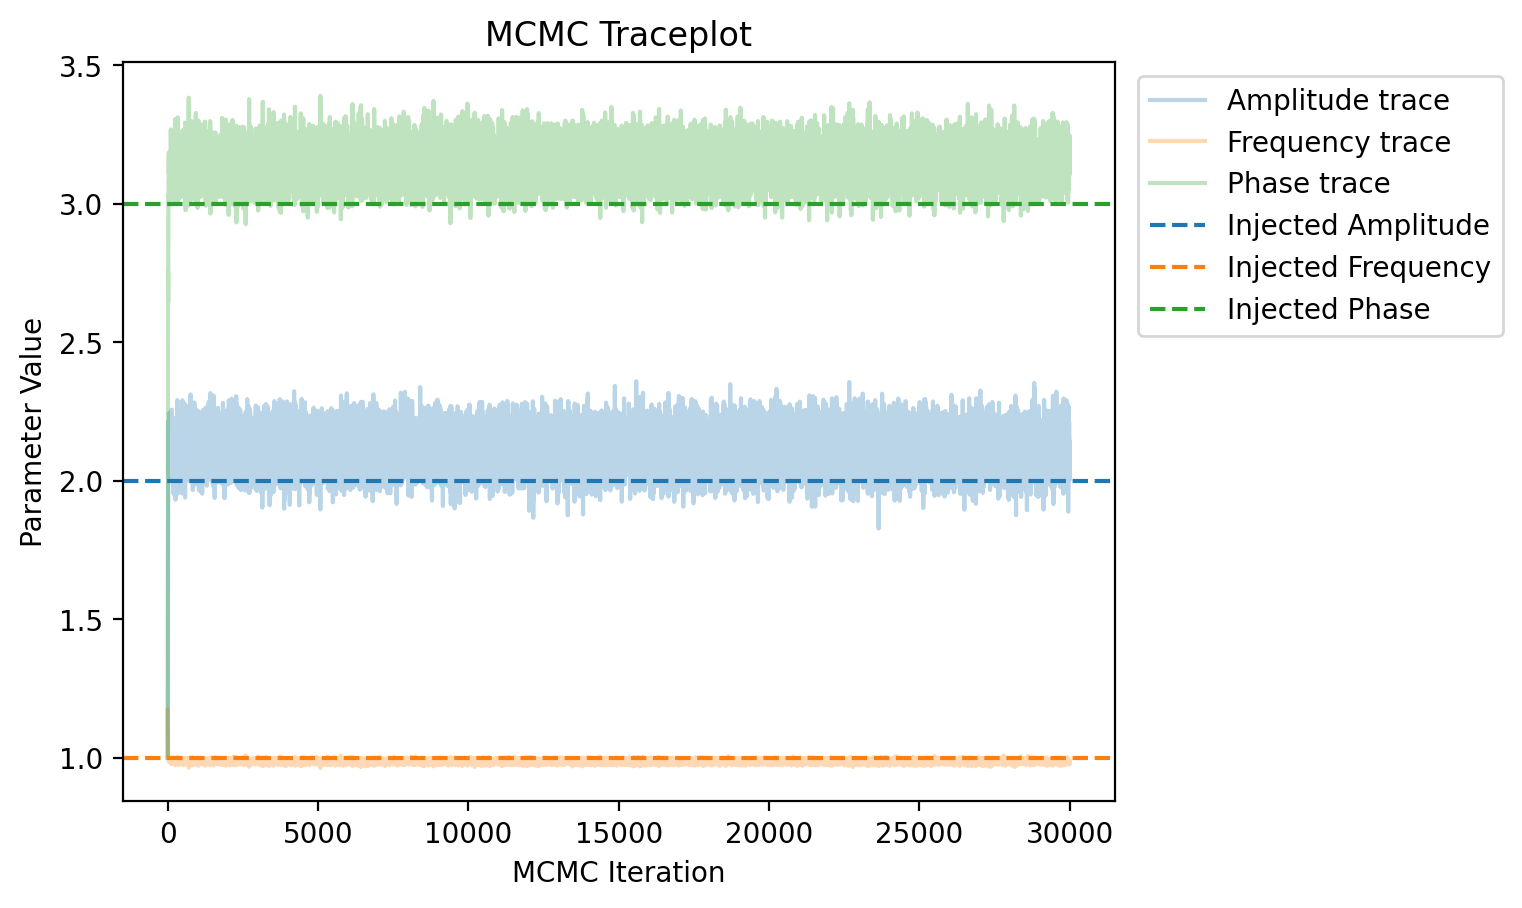

In [40]:
# Load the chain from a file
chain = np.loadtxt(loc+'chain_1.txt')[:,:3]

# Plot the trace plots.

plt.plot(chain[:,0],label='Amplitude trace',color='C0',alpha=0.3)
plt.plot(chain[:,1],label='Frequency trace',color='C1',alpha=0.3)
plt.plot(chain[:,2],label='Phase trace',color='C2',alpha=0.3)

plt.axhline(true_amplitude,linestyle='dashed',color='C0',label='Injected Amplitude')
plt.axhline(true_frequency,linestyle='dashed',color='C1',label='Injected Frequency')
plt.axhline(true_phase,linestyle='dashed',color='C2',label='Injected Phase')

plt.title('MCMC Traceplot')
plt.ylabel('Parameter Value')
plt.xlabel('MCMC Iteration')
plt.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left')
plt.show()

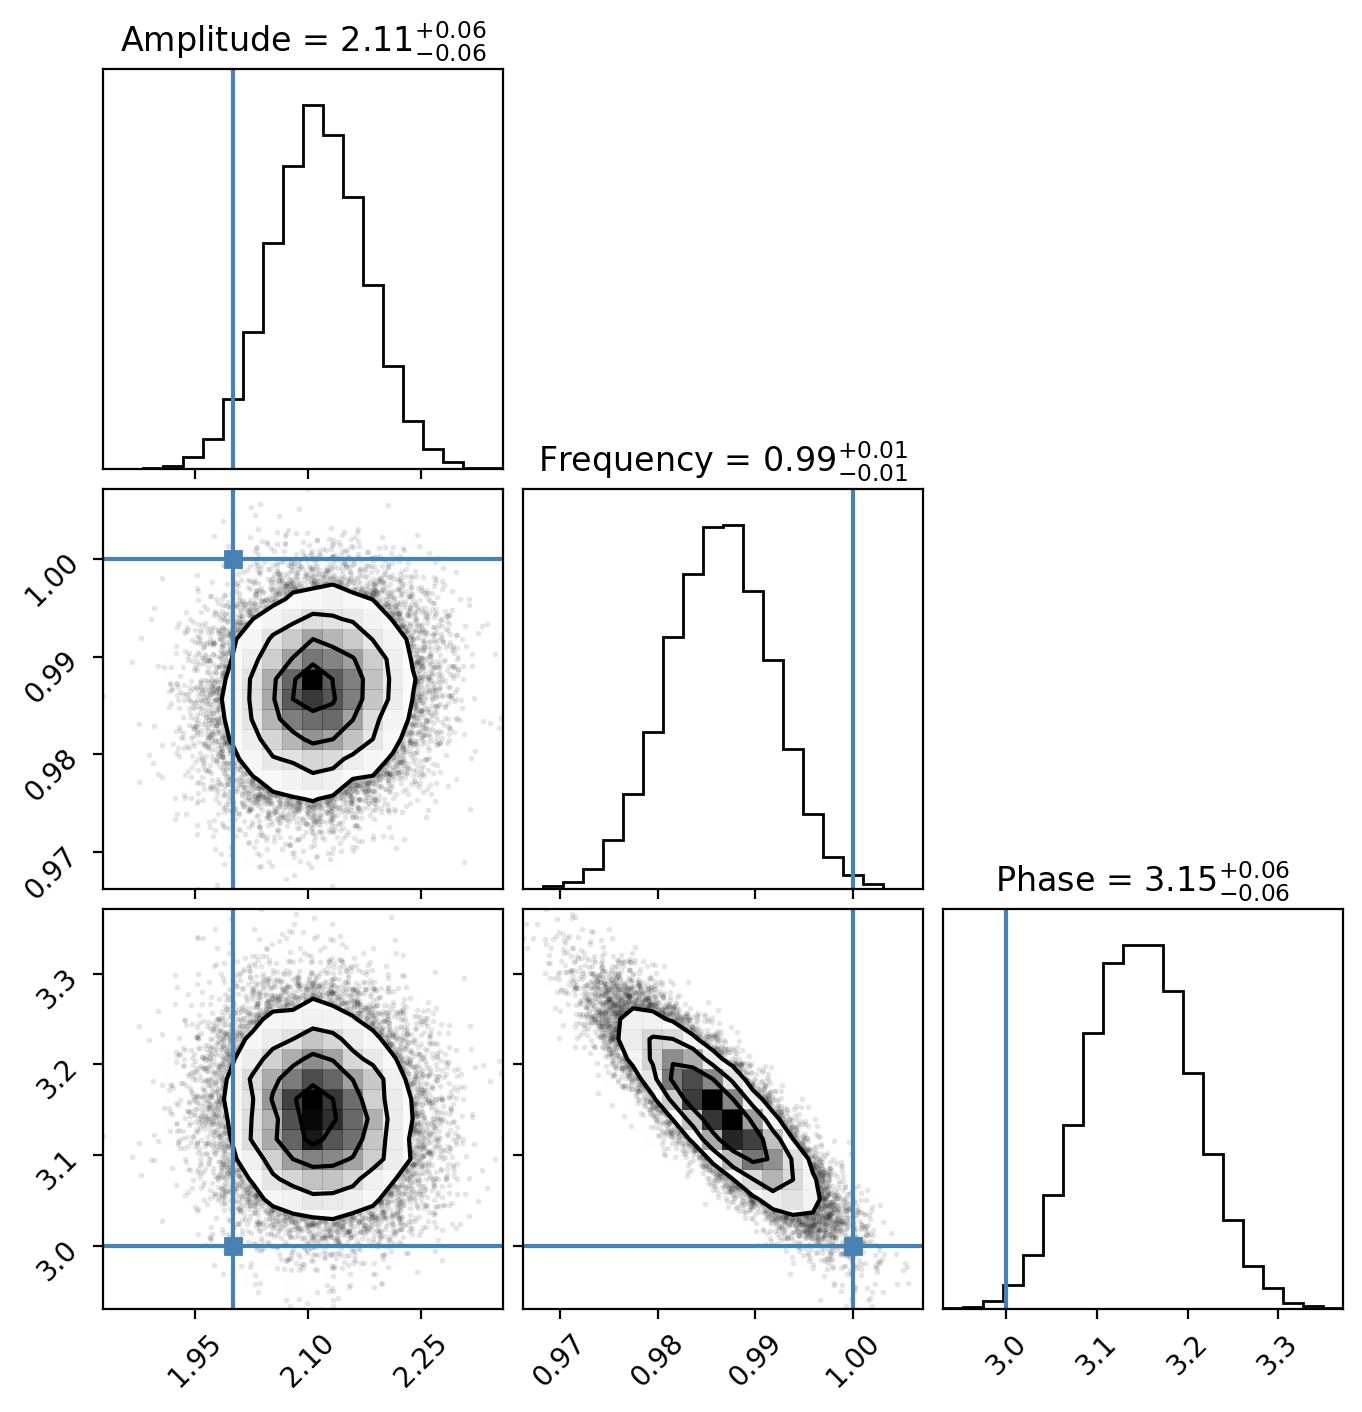

In [41]:
burn = int(0.25*len(chain))
corner(chain[burn:],titles=['Amplitude','Frequency','Phase'],show_titles=True,
       truths=[true_amplitude,true_frequency,true_phase])
plt.show()

Did PTMCMC do better than our MH_MCMC function? If so, why do you think that is? If not, why not?



# Bonus Tasks

Now that we have parameter estimates, what do we do with them? How do we know how significant they are? As you learned earlier, Bayesian model selection is the way to go for Bayesian statistics. However, Bayesfactors (how many times better is model A than model B) are notoriously hard to estimate. 

One more simple method for Bayesfactors is called the [Savage-Dickey density ratio](https://statproofbook.github.io/P/bf-sddr.html), or just Savage-Dickey Bayesfactors. This method involves finding a set of parameters in which one model is equivalent to another. 

In our simple sinusoid model. We could imagine a model consisting of only noise and no sinusoid. This noise-only model has an equivalence with the sinusoid model when the sinusoid model has 0 amplitude! So, to calculate the Bayesfactor between a sinusoid model with a noise-only model, we can take the ratio of the prior to the posterior at that equivalence point

$$B_{\rm{SD}} = \frac{p(A=0)}{p(d|A=0)}$$

Lets try that with our posterior!

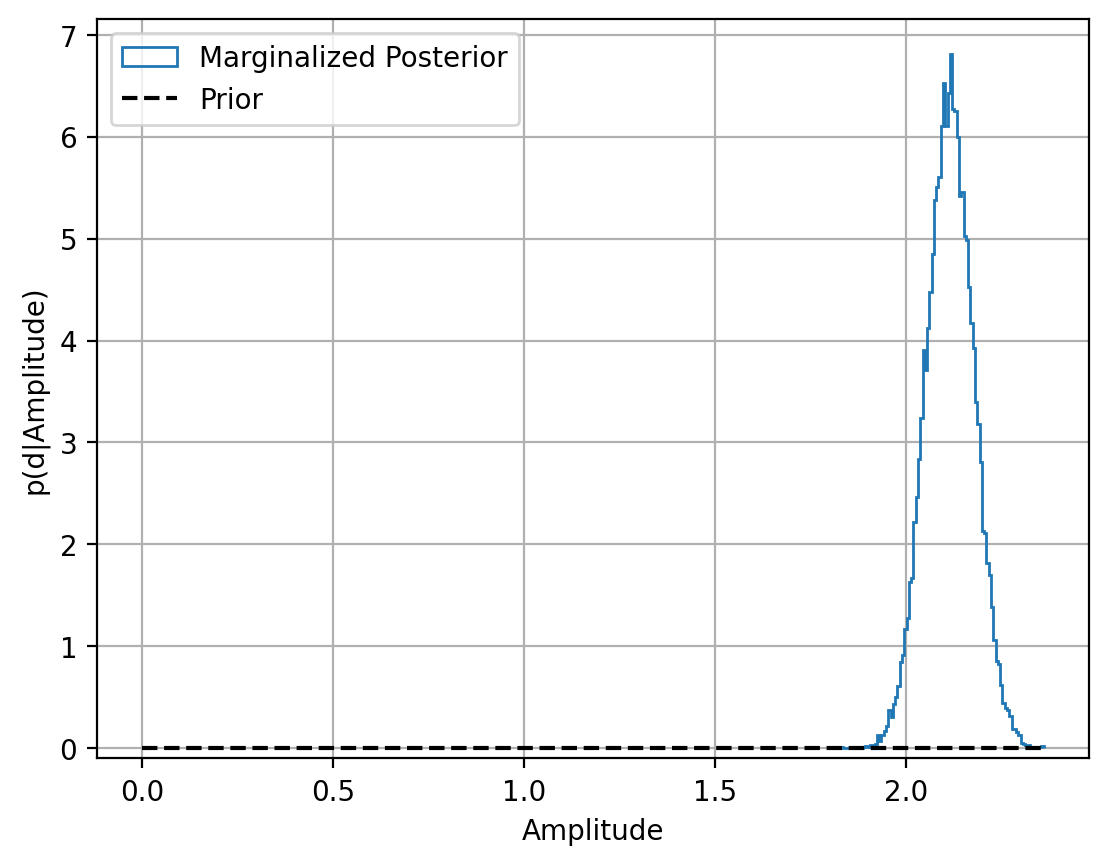

In [42]:
# Plot the posterior
plt.hist(chain[burn:,0],'auto',density=True,histtype='step',label='Marginalized Posterior')

# Plot the uniform prior
plt.hlines(np.exp(ln_prior([1,1,1])),0,np.max(chain[burn:,0]),colors='k',linestyles='dashed',label='Prior')

plt.ylim(-0.1)
plt.xlabel('Amplitude')
plt.ylabel('p(d|Amplitude)')
plt.legend()
plt.grid()
plt.show()

Do you see a problem? There are no samples at amplitude 0, and therefore we don't have a measure of the posterior all the way down there! Unfortunately we cannot use this method to calculate a Bayesfactor in this case.

But fear not! We have another numerical method to help! **Null-distribution testing!** We can test how important the presence of a signal is by creating statistically identical datasets with the signal removed.

One problem though, how? If we want to remove our signal, but we don't even know what it is, how can we do that? The answer is to find methods to destroy the signal while keeping every other property in place


## Destroying the signal

With our sinusoid example, we have a dataset which contains a time-varying signal with non-time varying noise. So what if we scrambled the time axis? There are many methods to do this, but for this example I will be using a technique called [bootstrapping](https://en.wikipedia.org/wiki/Bootstrapping#:~:text=Bootstrapping%20in%20business%20means%20starting,external%20help%20or%20working%20capital.). If we assume that each measurement is independent and no signal is present, then each measurement is a random draw from the white noise. We can then create bootstrapped datasets by taking N random samples from our real dataset to construct a new non-time-varrying dataset

You might be concerned about duplicated data, however bootstrapping is a thoroughly tested method to create independent yet statistically similar datasets.

In [43]:
# A function which creates a bootstrapped dataset

def create_bootstrap(data):
    randi = np.random.randint(0,len(data),len(data))
    new = np.zeros_like(data)
    new = data[randi]
    return new

Now lets plot the data, does the sinusoid still appear?

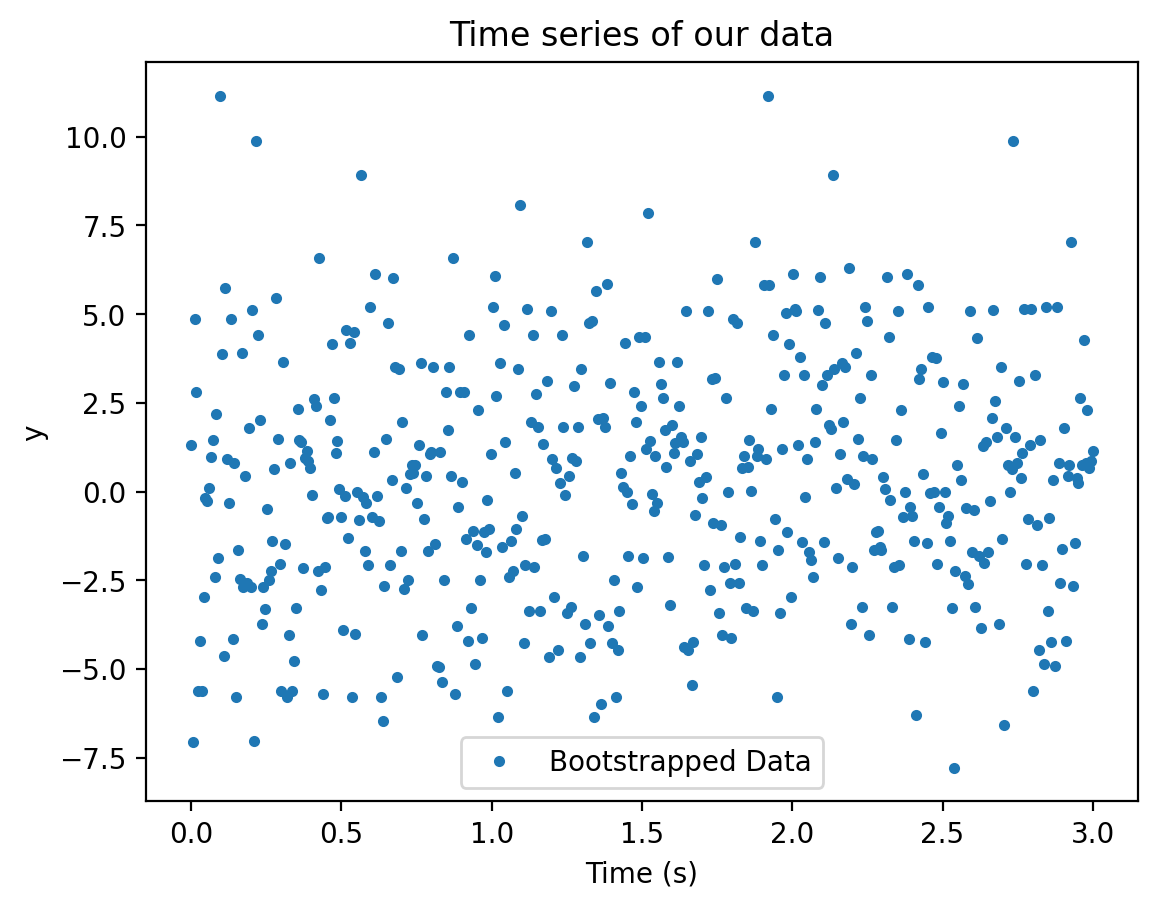

In [44]:
# See a sinusoid anymore?
bootstrap_data = create_bootstrap(data)


plt.plot(time,bootstrap_data,'.',label='Bootstrapped Data',)
plt.title('Time series of our data')
plt.xlabel('Time (s)')
plt.ylabel('y')
plt.legend()
plt.show()

## Running the bootstrapped data through an MCMC

With our bootstrapped dataset we can now run through all the same steps as we did before. Thankfully almost eveything is the same except for the log likelihood function

In [48]:
## Task 6: Creating a bootstrapped log likelihood function ##

def bootstrap_ln_likelihood(params):
    # First calculate your model
    mod = np.zeros(params) # Replace this with an array of your model

    # THIS STEP IS DIFFERENT FROM THE REGULAR LOG LIKELIHOOD
    # Next, get all of your residuals (hint: r_i = bootstrap_i - m_i)
    residuals = np.zeros(len(time)) # Replace this with an array of residuals

    residuals = bootstrap_data - mod # Replace this with an array of residuals

    # Now calculate the log likelihood! Note that you will need a sum!
    ln_like = -(1/2)*np.sum(residuals**2)
    return ln_like

In [49]:
## Task 6: Kyle's solution ##

def bootstrap_ln_likelihood(params):
    # First calculate your model
    mod = model(params) # Replace this with an array of your model

    # THIS STEP IS DIFFERENT FROM THE REGULAR LOG LIKELIHOOD
    # Next, get all of your residuals (hint: r_i = bootstrap_i - m_i)
    residuals = bootstrap_data - mod # Replace this with an array of residuals

    # Now calculate the log likelihood! Note that you will need a sum!
    ln_like = -(1/2)*np.sum(residuals**2)
    return ln_like

Now put those into an MCMC! Using the same priors as before

In [50]:
# Define some location to save the MCMC output
loc = 'BootstrapSineMCMC/'

# Give it a starting guess
x0 = np.array([1., 1., 1.])

# Give it a starting jump covariance matrix. Don't worry, its adaptive!
cov = np.diag([0.01, 0.01, 0.01]) 

# Construct our sampler using the functions we already made!
sampler = PTSampler(ndim=3, logl=bootstrap_ln_likelihood, logp=ln_prior, cov=cov , outDir=loc)

# Now sample!
sampler.sample(x0, Niter=int(3e5))

Finished 3.33 percent in 1.010982 s Acceptance rate = 0.143978Adding DE jump with weight 20
Finished 100.00 percent in 37.221498 s Acceptance rate = 0.390203
Run Complete


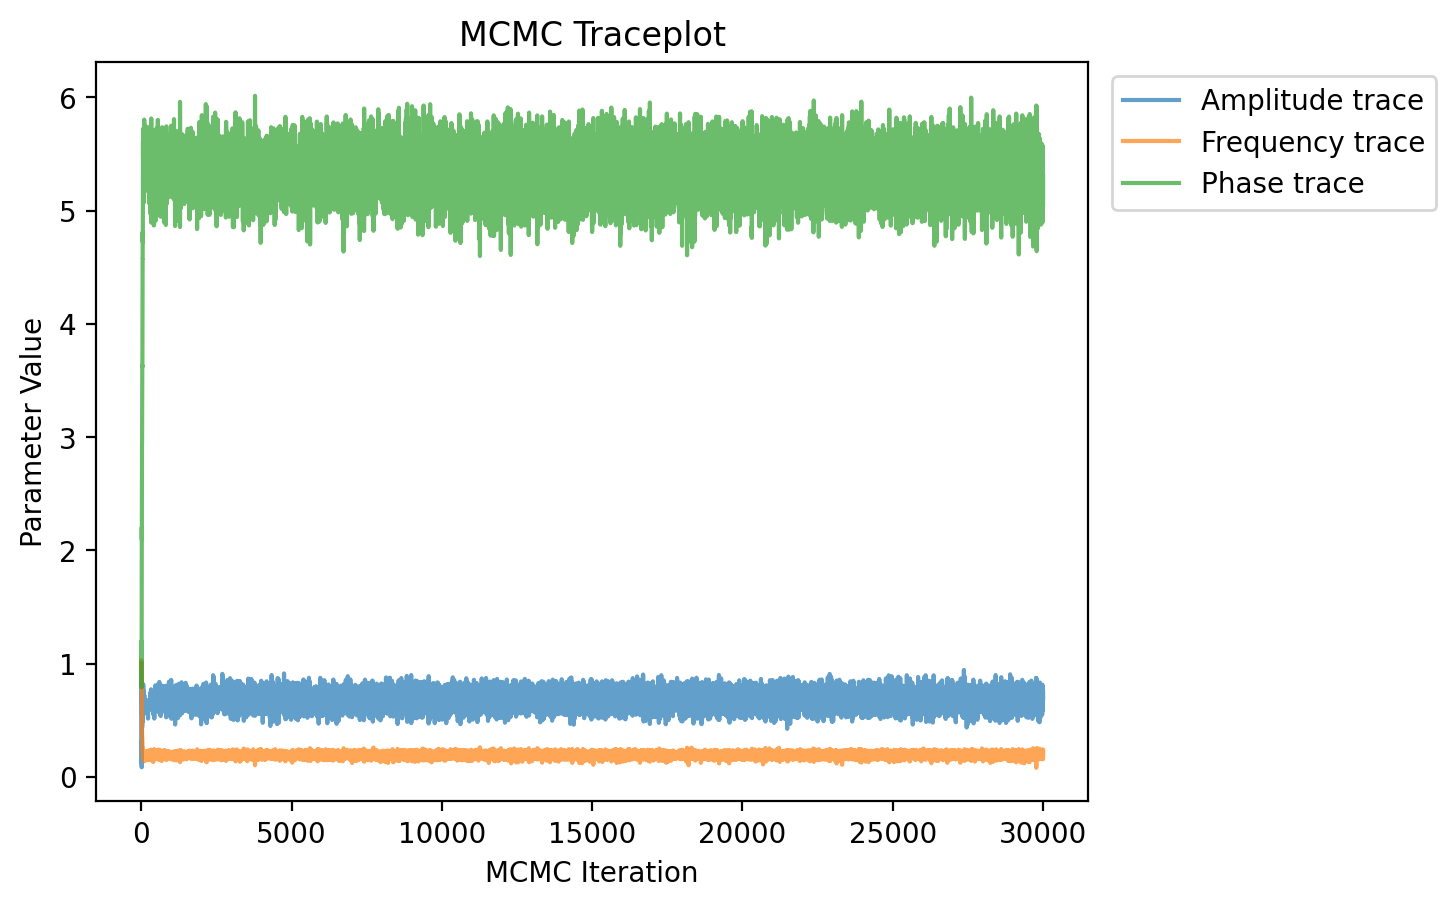

In [51]:
# Load the chain from a file
chain = np.loadtxt(loc+'chain_1.txt')[:,:3]

# Plot the trace plots.

plt.plot(chain[:,0],label='Amplitude trace',color='C0',alpha=0.7)
plt.plot(chain[:,1],label='Frequency trace',color='C1',alpha=0.7)
plt.plot(chain[:,2],label='Phase trace',color='C2',alpha=0.7)


plt.title('MCMC Traceplot')
plt.ylabel('Parameter Value')
plt.xlabel('MCMC Iteration')
plt.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left')
plt.show()

Now plot the corner plot. 

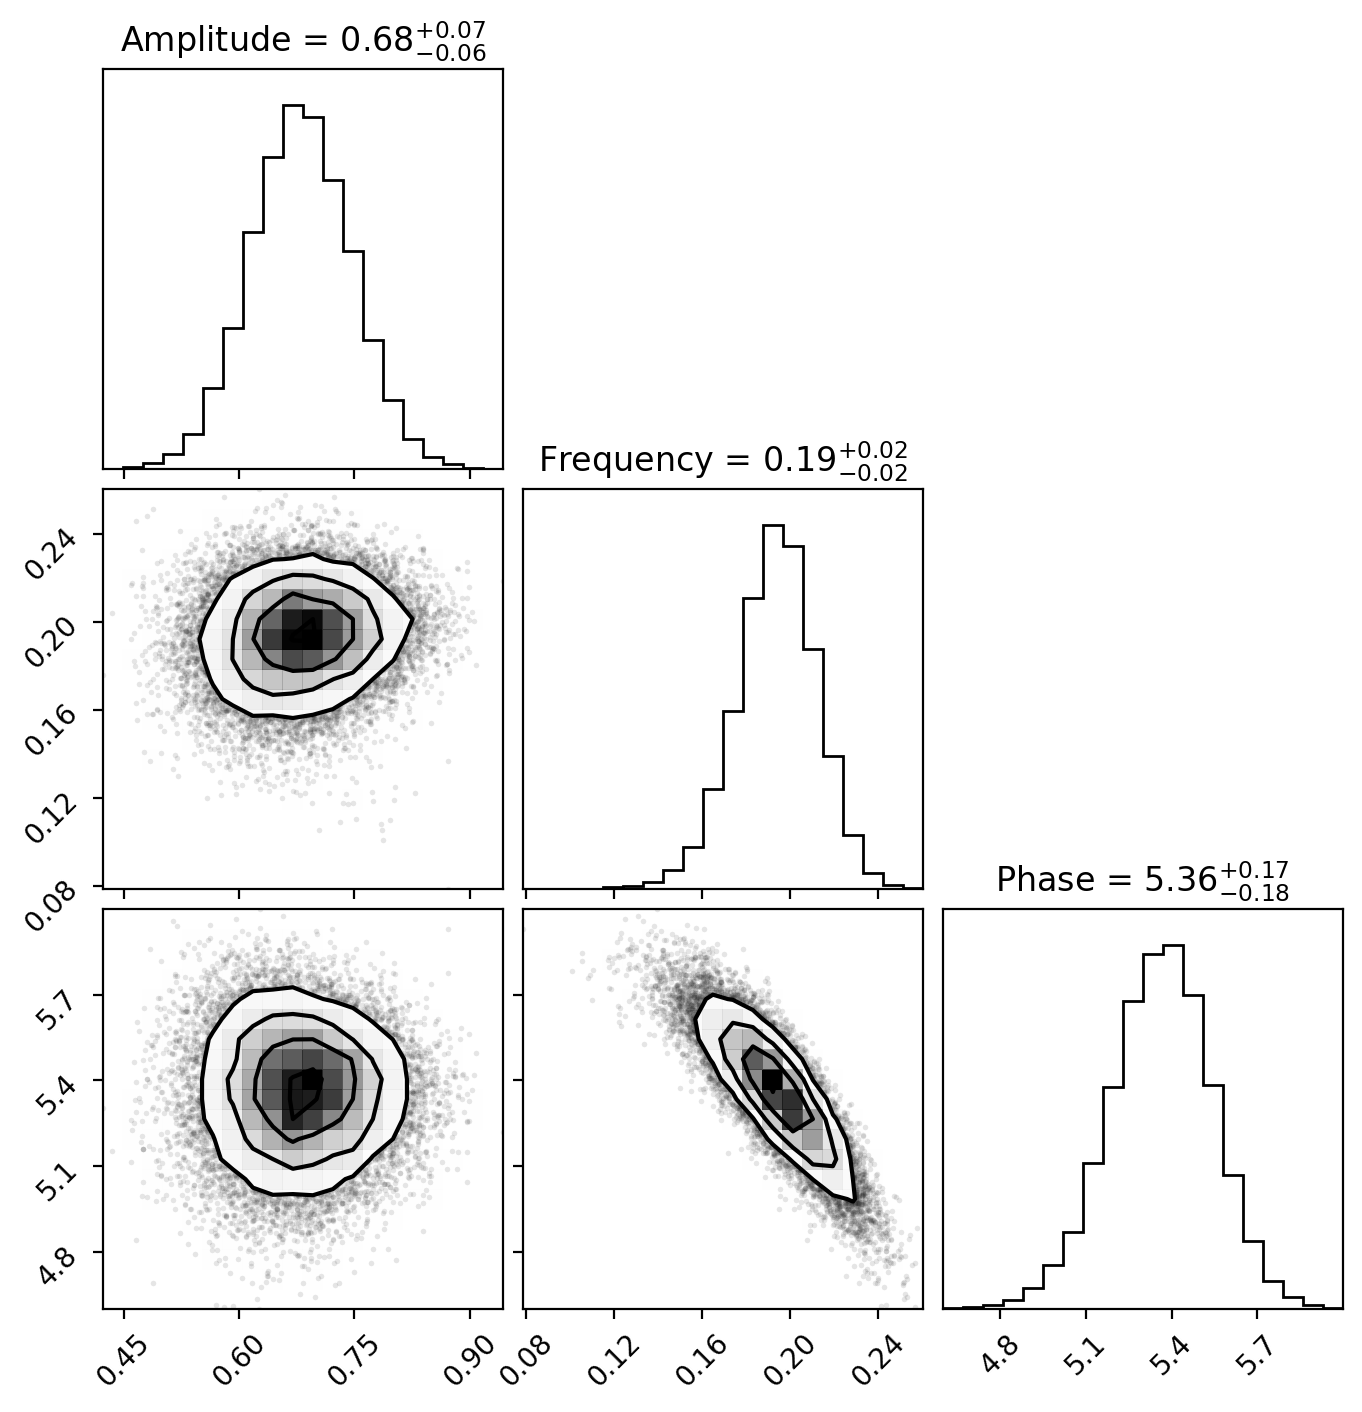

In [52]:
burn = int(len(chain)*0.25)
corner(chain[burn:],titles=['Amplitude','Frequency','Phase'],show_titles=True,)
plt.show()

Now it might be concerning that the amplitude can be constrained, but fear not, for this is not a bug, but rather a result of mis-modeling. If you used a model with only noise, I can assure you that the Bayesfactor for a noise-only model will be larger than that of a sinusoid.

So now what? We've got a null-distribution dataset, but how do we get a significance value? Well, you can do so by simulating MANY null-distribution datasets and find the occurance rate of a sinusoid with the properties you measured in the dataset in the many bootstrapped datasets you make. Basically you'd find the false alarm rate of such a detection.

## Bonus things to try

Try creating different types of signals and run them through MCMCs. 
- We clearly had some issues with sinusoids, but what about other time, varying processes? 
- Maybe try fixing the frequency of the sinusoid, does that help with the MCMC?
- How does the recovery of two sinusoids work?
- Try a different model with the same data set. Does the new model fit the data well?
- Mess around with non-uniform priors! Maybe try a log-uniform prior on the amplitude!

Feel free to ask for more challenge problems if none of these interest you! I'd be happy to help!